# A code example: The intraday seasonality of the spread

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
def binning(x,y,nbin=10,eq = True):
    step = (np.max(x)-np.min(x))/(nbin)
    X = []
    Y = []
    Yerr = []
    tmpY = []
    start = np.min(x)+step
    if eq:
        for i in range(len(x)):
            while x[i] > start:
                X.append(start-step/2)
                Y.append(np.mean(tmpY))
                #Xerr.append(np.std(tmpX,ddof=1) /np.sqrt(len(tmpX)) )
                Yerr.append(np.std(tmpY,ddof=1) /np.sqrt(len(tmpY)) )
                start += step
                tmpY=[]
                pass
            tmpY.append(y[i])
            pass
        if len(tmpY)!=0:
            X.append(start-step/2)
            Y.append(np.mean(tmpY))
            Yerr.append(np.std(tmpY,ddof=1) /np.sqrt(len(tmpY)) )
        return X,Y,Yerr
        pass
    else:
        tmpX = []
        Xerr = []
        for i in range(len(x)):
            while x[i] > start:
                X.append(np.mean(tmpX))
                Y.append(np.mean(tmpY))
                Xerr.append(np.std(tmpX,ddof=1) /np.sqrt(len(tmpX)) )
                Yerr.append(np.std(tmpY,ddof=1) /np.sqrt(len(tmpY)) )
                start += step
                tmpX=[]
                tmpY=[]
                pass
            tmpX.append(x[i])
            tmpY.append(y[i])
            pass
        if len(tmpY)!=0:
            X.append(np.mean(tmpX))
            Y.append(np.mean(tmpY))
            Xerr.append(np.std(tmpX,ddof=1) /np.sqrt(len(tmpX)) )
            Yerr.append(np.std(tmpY,ddof=1) /np.sqrt(len(tmpY)) )
        return X, Y, Yerr

In [44]:
def PreProcessing(t,spread):
    T = np.zeros(len(t))
    Spread = np.zeros(len(t))
    prev = t[0]
    n = 0
    for i in range(len(t)):
        n += (prev != t[i])
        T[n] = t[i]
        Spread[n] = spread[i]
        prev = t[i]
        pass
    return T[:n+1],Spread[:n+1]

In [60]:
def TimeMean(t, y, prev, start, end):
    T = np.diff(t)
    Y = np.sum(y[1:]*T) + (end-t[-1])*y[-1] + (t[0]-start)*prev
    return Y/(end-start)

def IntradaySeasonality_Spread(t,spread, start=34200 , end= 57600 ,step = 60):
    t = np.array(t)
    spread = np.array(spread)
    T = np.arange(start,end+step,step)
    prev = spread[0]
    result_S = np.zeros(len(T)-1)
    for i in range(len(T)-1):
        use = ((T[i]<=t) & (t<T[i+1]))
        tmp_t = t[use]
        tmp_s = spread[use]
        result_S[i] = TimeMean(tmp_t, tmp_s, prev, T[i], T[i+1])
        prev = tmp_s[-1]
        pass
    
    return T[1:] -step/2, result_S

In [89]:
def TimeMean(t, y, prev, start, end):
    T = np.diff(t)
    Y = np.sum(y[1:]*T) + (end-t[-1])*y[-1] + (t[0]-start)*prev
    return Y/(end-start)

def IntradaySeasonality_Spread(t,spread, start=34200 , end= 57600 ,step = 60):
    t = np.array(t)
    spread = np.array(spread)
    T = np.arange(start,end+step,step)
    prev = spread[0]
    result_S = np.zeros(len(T)-1)
    for i in range(len(T)-1):
        use = ((T[i]<=t) & (t<T[i+1]))
        tmp_t = t[use]
        tmp_s = spread[use]
        result_S[i] = TimeMean(tmp_t, tmp_s, prev, T[i], T[i+1])
        prev = tmp_s[-1]
        pass
    
    return T[1:] -step/2, result_S

In [ ]:
INTC_LOB   = np.sort(["../../Data/INTC/"+i for i in os.listdir("../../Data/INTC") if i[-8]=="k"])
TSLA_LOB   = np.sort(["../../Data/TSLA/"+i for i in os.listdir("../../Data/TSLA") if i[-8]=="k"])
INTC_order = np.sort(["../../Data/INTC/"+i for i in os.listdir("../../Data/INTC") if i[-8]!="k"])
TSLA_order = np.sort(["../../Data/TSLA/"+i for i in os.listdir("../../Data/TSLA") if i[-8]!="k"])

In [123]:
TSLA_t,TSLA_y = [[] for i in range(len(TSLA_order))],[[] for i in range(len(TSLA_order))]
n = 0
for i,z in zip(TSLA_order,TSLA_LOB):
    data = pd.read_csv(i,header=None)[0]
    lob = pd.read_csv(z,header=None)[[0,2]]
    spread = lob[0]-lob[2]
    a,b = PreProcessing(data.values,spread.values)
    a,b = IntradaySeasonality_Spread(a,b, start=34200 , end= 57600 ,step = 60)
    TSLA_t[n] = a.copy()
    TSLA_y[n] = b.copy()
    n+=1
    pass

INTC_t,INTC_y = [[] for i in range(len(INTC_order))],[[] for i in range(len(INTC_order))]
n = 0
for i,z in zip(TSLA_order,TSLA_LOB):
    data = pd.read_csv(i,header=None)[0]
    lob = pd.read_csv(z,header=None)[[0,2]]
    spread = lob[0]-lob[2]
    a,b = PreProcessing(data.values,spread.values)
    a,b = IntradaySeasonality_Spread(a,b, start=34200 , end= 57600 ,step = 60)
    INTC_t[n] = a.copy()
    INTC_y[n] = b.copy()
    n+=1
    pass


In [124]:
INTC_y = np.array(INTC_y)
INTC_Y = [np.mean(INTC_y[:,i]) for  i in range(len(INTC_t[0]))]
INTC_Yerr = [np.std(INTC_y[:,i],ddof=1)/np.sqrt(len(INTC_t)) for  i in range(len(INTC_t[0]))]

TSLA_y = np.array(TSLA_y)
TSLA_Y = [np.mean(TSLA_y[:,i]) for  i in range(len(TSLA_t[0]))]
TSLA_Yerr = [np.std(TSLA_y[:,i],ddof=1)/np.sqrt(len(TSLA_t)) for  i in range(len(TSLA_t[0]))]

Text(0.5, 1.0, 'TSLA')

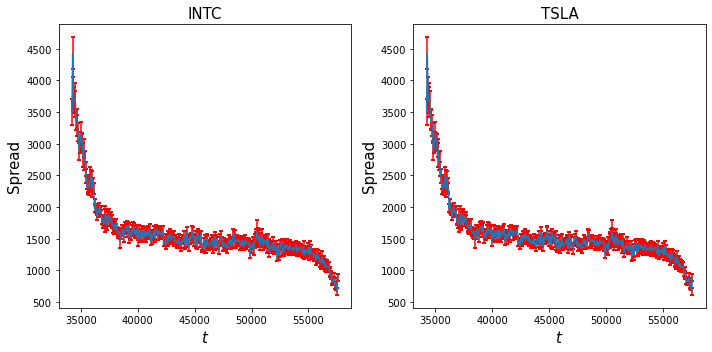

In [127]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5),tight_layout=True)
ax1.errorbar(TSLA_t[0],INTC_Y,INTC_Yerr,capthick=2,capsize=2,ecolor="red")
ax1.set_ylabel("Spread",fontsize=15)
ax1.set_xlabel(r"$t$",fontsize=15)
ax1.set_title("INTC",fontsize=15)

ax2.errorbar(TSLA_t[0],TSLA_Y,TSLA_Yerr,capthick=2,capsize=2,ecolor="red")
ax2.set_ylabel("Spread",fontsize=15)
ax2.set_xlabel(r"$t$",fontsize=15)
ax2.set_title("TSLA",fontsize=15)


In [130]:
pd.read_csv(z,header=None)#[[0,2]]

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,2039700,273,2038000,5,2039800,400,2035200,200,2041700,100,...,2019800,50,2059200,100,2017700,100,2081000,100,2016000,100
1,2039700,268,2038000,5,2039800,400,2035200,200,2041700,100,...,2019800,50,2059200,100,2017700,100,2081000,100,2016000,100
2,2039700,100,2038000,5,2039800,400,2035200,200,2041700,100,...,2019800,50,2059200,100,2017700,100,2081000,100,2016000,100
3,2039700,100,2038000,5,2039800,400,2030300,100,2041700,100,...,2017700,100,2059200,100,2016000,100,2081000,100,2015000,100
4,2039700,100,2038000,5,2039800,400,2030300,100,2041700,100,...,2017700,100,2059200,100,2016000,100,2081000,100,2015000,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317885,2036000,8040,2035400,205,2036100,4400,2035100,300,2036400,200,...,2034000,5,2037400,2800,2033900,100,2037500,1200,2033300,101
317886,2036000,8040,2035400,205,2036100,4400,2035200,1400,2036400,200,...,2034400,200,2037400,2800,2034000,5,2037500,1200,2033900,100
317887,2036000,7561,2035400,205,2036100,4400,2035200,1400,2036400,200,...,2034400,200,2037400,2800,2034000,5,2037500,1200,2033900,100
317888,2036000,7061,2035400,205,2036100,4400,2035200,1400,2036400,200,...,2034400,200,2037400,2800,2034000,5,2037500,1200,2033900,100


In [132]:
INTC_2t,INTC_2y = [[] for i in range(len(INTC_order))],[[] for i in range(len(INTC_order))]
n = 0
for i,z in zip(TSLA_order,TSLA_LOB):
    data = pd.read_csv(i,header=None)[0]
    lob = pd.read_csv(z,header=None)[[4,6]]
    spread = lob[4]-lob[6]
    a,b = PreProcessing(data.values,spread.values)
    a,b = IntradaySeasonality_Spread(a,b, start=34200 , end= 57600 ,step = 60)
    INTC_2t[n] = a.copy()
    INTC_2y[n] = b.copy()
    n+=1
    pass

In [133]:
INTC_2y = np.array(INTC_2y)
INTC_2Y = [np.mean(INTC_2y[:,i]) for  i in range(len(INTC_t[0]))]
INTC_2Yerr = [np.std(INTC_2y[:,i],ddof=1)/np.sqrt(len(INTC_t)) for  i in range(len(INTC_t[0]))]


Text(0.5, 1.0, 'INTC 2nd')

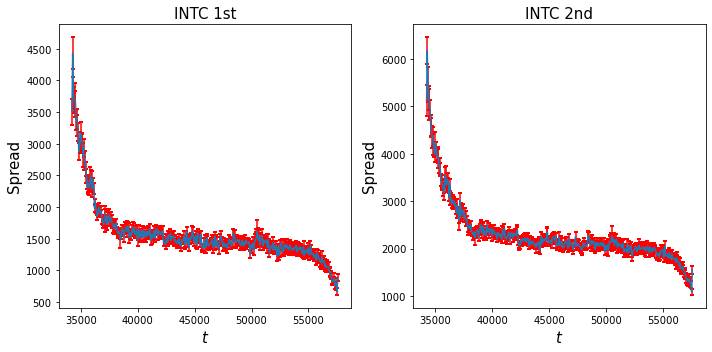

In [135]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5),tight_layout=True)
ax1.errorbar(TSLA_t[0],INTC_Y,INTC_Yerr,capthick=2,capsize=2,ecolor="red")
ax1.set_ylabel("Spread",fontsize=15)
ax1.set_xlabel(r"$t$",fontsize=15)
ax1.set_title("INTC 1st",fontsize=15)

ax2.errorbar(TSLA_t[0],INTC_2Y,INTC_2Yerr,capthick=2,capsize=2,ecolor="red")
ax2.set_ylabel("Spread",fontsize=15)
ax2.set_xlabel(r"$t$",fontsize=15)
ax2.set_title("INTC 2nd",fontsize=15)